In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import db
import pam
import utils as ut
import features as ft
import dtw
import clustering_evaluation as ce
import seq2seq as s2s

import time

from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from sklearn.metrics import pairwise_distances,homogeneity_completeness_v_measure,silhouette_score,calinski_harabaz_score
import matplotlib.cm as cm
from sklearn.decomposition import PCA

# Get the data

In [3]:
DATA_PATH = "data/laurier/"
DATA_BASE = DATA_PATH + "laurier.sqlite"
SAVE_PATH = DATA_PATH + "generated_data/"
FRAME_PATH = DATA_PATH + "laurier.jpg"
VIDEO_PATH = DATA_PATH + "laurier.avi"
HOMOGRAPHY = DATA_PATH + "laurier-homography.txt"
DISTANCES = SAVE_PATH + "distances/cityblock_50.txt"

### Load trajectories from path

In [4]:
# get every trajectories in the database
trajectories_u = db.get_trajectories(DATA_BASE)

# number of best trajectories to keep for each object
nb_trajectories_per_object = 10

#trajectories ordered by object, database trajectory ids ordered by objects
trajectories_po,ids_po,nb_objects = db.get_trajectories_by_object(DATA_BASE)
trajectories_po,ids_po = db.filter_trajectories(nb_trajectories_per_object, trajectories_po, ids_po)
pixel_trajectories_po = [[ut.to_pixel(t,HOMOGRAPHY) for t in trajectories] for trajectories in trajectories_po]

#total number of selected trajectories
nb_trajectories = nb_trajectories_per_object * nb_objects

# list of every selected trajectory, 
trajectories = [t for o in trajectories_po for t in o]
# ids of every selected trajectory
ids = [i for o in ids_po for i in o]
# trajectories in pixel space, for displaying purposes only
pixel_trajectories = [ut.to_pixel(t,HOMOGRAPHY) for t in trajectories]

In [5]:
nb_objects

5

In [6]:
nb_trajectories

50

### Visualize selected trajectories in pixel space

The red dots are the beginnings of the trajectories, while the green ones are their ends

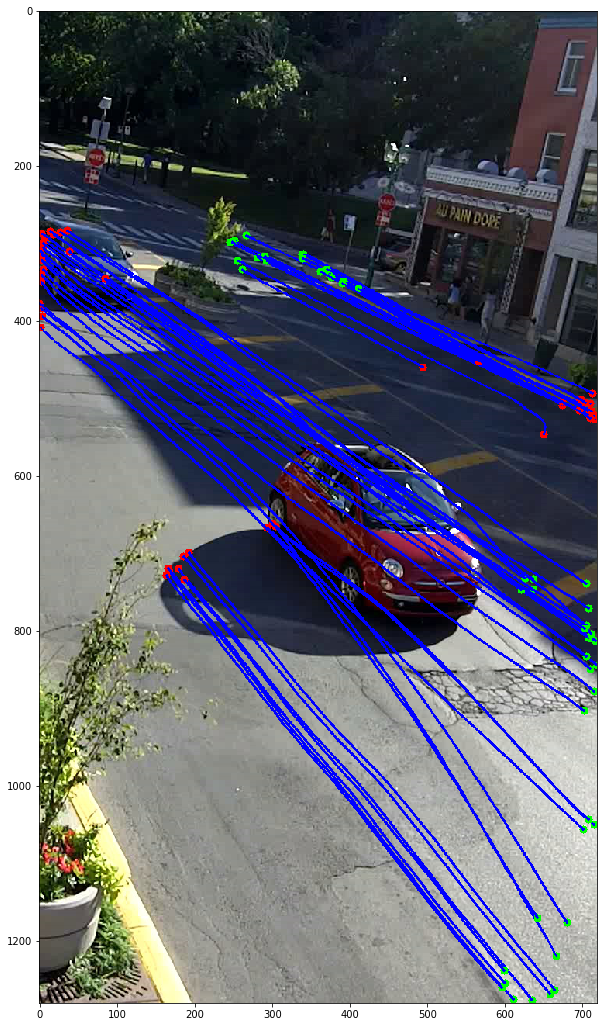

In [7]:
ut.plot_trajectories(FRAME_PATH,pixel_trajectories)

## Trajectory discretization

In [84]:
square_size = 0.111
discretized_trajectories = [dtw.discretize(trajectory,square_size) for trajectory in trajectories]

On the following plots we can see the trajectory number of points distribution before and after the discretization

(array([10.,  0.,  0.,  2., 13.,  1.,  7.,  3.,  7.,  7.]),
 array([ 40.,  52.,  64.,  76.,  88., 100., 112., 124., 136., 148., 160.]),
 <a list of 10 Patch objects>)

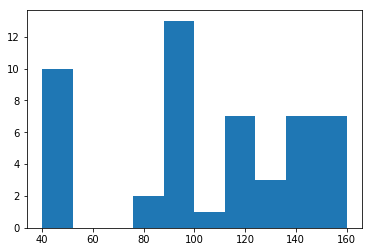

In [33]:
plt.hist([len(t) for t in trajectories])

(array([10.,  0.,  0.,  2., 12.,  2.,  7.,  3.,  6.,  8.]),
 array([ 40. ,  51.6,  63.2,  74.8,  86.4,  98. , 109.6, 121.2, 132.8,
        144.4, 156. ]),
 <a list of 10 Patch objects>)

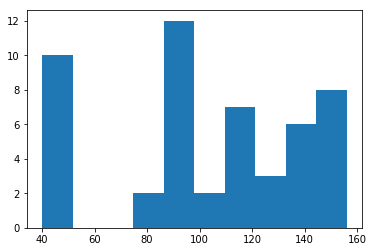

In [34]:
plt.hist([len(t) for t in discretized_trajectories])

### Effect of discretization on clustering quality

In [27]:
#get the ground truth
labels_true = ce.get_ground_truth(ids,ids_po)  
square_sizes = np.linspace(0.0, 1.0, num=10)
nb_clusters = nb_objects
values = []
for square_size in square_sizes:
    discretized_trajectories = [dtw.discretize(trajectory,square_size) for trajectory in trajectories]
    discretized_features = [ft.compute_features(trajectory) for trajectory in discretized_trajectories]
    discretized_features = pd.DataFrame(ft.standardize_features(discretized_features))
    pca = PCA(n_components=0.99)
    features_pca = pca.fit_transform(discretized_features)
    clusters = KMeans(n_clusters = nb_objects).fit_predict(features_pca)
    _,_,v = homogeneity_completeness_v_measure(labels_true, clusters)
    values.append(v)

In [28]:
square_sizes[np.argmax(values)],np.max(values)

(0.1111111111111111, 0.8914652557039909)

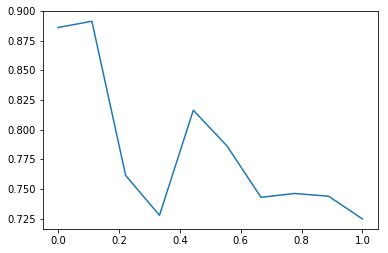

In [30]:
plt.plot(square_sizes,values)

# Compute features

## Normal trajectories

In [42]:
start = time.time()
features = [ft.compute_features(trajectory) for trajectory in trajectories]
features = pd.DataFrame(ft.standardize_features(features))
print("execution duration: " + str(time.time()-start))

execution duration: 1.64360713959


## Discretized trajectories

In [85]:
start = time.time()
discretized_features = [ft.compute_features(trajectory) for trajectory in discretized_trajectories]
discretized_features = pd.DataFrame(ft.standardize_features(discretized_features))
print("execution duration: " + str(time.time()-start))

execution duration: 1.84399199486


## PCA

In [69]:
import matplotlib.cm as cm
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
features_pca = pca.fit_transform(discretized_features)
pca.n_components_

13

We will use PCA because it allows to keep 99% of the the data variance while reducing the number of features from 50 to 13

# Clustering evaluation

## Supervised

COnsidering the fact that, the trajectories are initially grouped by object, we can evaluate the quality of the clustering, using these groups as ground truth. And setting the number of clusters required to the number of objects in the database

In [38]:
#get the ground truth
labels_true = ce.get_ground_truth(ids,ids_po)   

### KMEANS

For k-means, take the mean/best performance over a certain number of iterations due to the randomness of initialization.
We use v-measure for evaluation

In [39]:
best_random_state = ce.best_model_rand_init(100,features_pca,labels_true,nb_objects)

clusters = KMeans(n_clusters=nb_objects, random_state = best_random_state).fit_predict(features_pca)

(0.8366700774642762, 0.9539407202946291, 0.8914652557039909)


## Hierarchical

In [40]:
clusters = AgglomerativeClustering(n_clusters = nb_objects).fit_predict(features_pca)
homogeneity_completeness_v_measure(labels_true, clusters)

(0.8366700774642762, 0.9539407202946291, 0.8914652557039909)

## K-MEDOIDS

In [95]:
start = time.time()

distance_matrix = pairwise_distances(features,metric="manhattan")
medoids_idx, clusters =pam.pam(distance_matrix, nb_objects)

print(time.time() - start)
homogeneity_completeness_v_measure(labels_true, clusters)

0.0593919754028


(1.0, 1.0, 1.0)

In [86]:
start = time.time()

distance_matrix = pairwise_distances(discretized_features,metric="manhattan")
medoids_idx, clusters =pam.pam(distance_matrix, nb_objects)

print(time.time() - start)
homogeneity_completeness_v_measure(labels_true, clusters)

0.078222990036


(0.8813534532688833, 0.9109702202846304, 0.895917139654968)

In [41]:
start = time.time()

distance_matrix = pairwise_distances(features_pca,metric="manhattan")
medoids_idx, clusters =pam.pam(distance_matrix, nb_objects)

print(time.time() - start)
homogeneity_completeness_v_measure(labels_true, clusters)

0.0610778331757


(0.881353453268883, 0.9109702202846303, 0.8959171396549679)

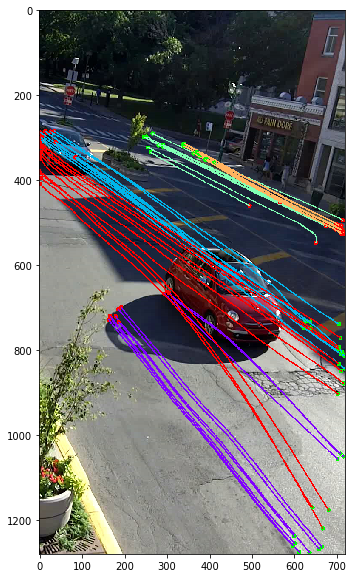

In [96]:
ut.plot_trajectories_by_groups(FRAME_PATH,pixel_trajectories_po)

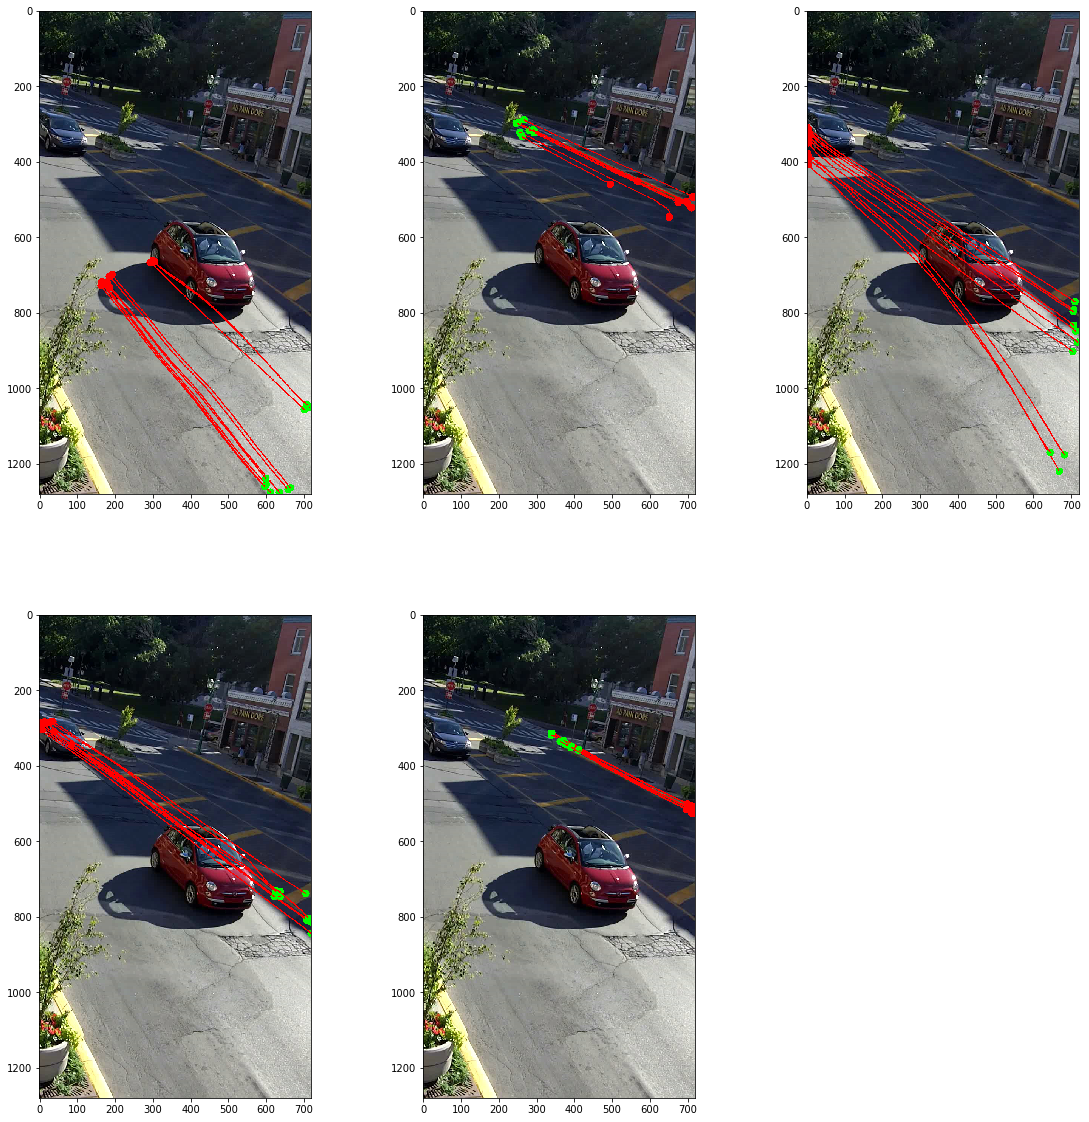

In [97]:
ut.display_clusters_oat_i(clusters,FRAME_PATH,pixel_trajectories)

## Observations

With a number of trajectories per object greater than 5, pam algorithm without discretiztion gets the the ground truth as clustering result.

## Unsupervised

In [49]:
def u_clustering_eval(max_clusters,algorithm,X):
    silhouette = []
    calinski_index = []
    for i in range(2,max_clusters):
        algorithm.set_params(n_clusters=i)
        clusters = algorithm.fit_predict(X)
        s = silhouette_score(X, clusters, metric='euclidean')
        c = calinski_harabaz_score(X, clusters) 
        silhouette.append(s)
        calinski_index.append(c)
    return silhouette, calinski_index

### KMEANS

In [70]:
max_clusters = nb_trajectories
silhouette, _ = u_clustering_eval(max_clusters,KMeans(),features_pca)
np.argmax(silhouette)+2,np.max(silhouette)

(4, 0.5829772251336254)

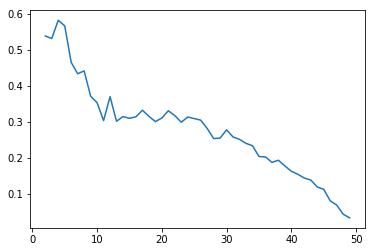

In [71]:
plt.plot(np.arange(2,max_clusters,1),silhouette)

### Hierarchical

In [72]:
max_clusters = nb_trajectories
silhouette, _ = u_clustering_eval(max_clusters,AgglomerativeClustering(),features_pca)
np.argmax(silhouette)+2,np.max(silhouette)

(4, 0.5829772251336254)

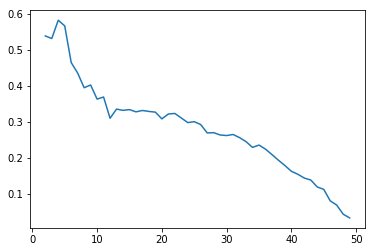

In [73]:
plt.plot(np.arange(2,max_clusters,1),silhouette)

### PAM

In [92]:
max_clusters = nb_trajectories
silhouette = []
calinski_index = []
for i in range(2,max_clusters):
    distance_matrix = pairwise_distances(features_pca,metric="manhattan")
    medoids_idx, clusters =pam.pam(distance_matrix, i)
    s = silhouette_score(features_pca, clusters, metric='euclidean')
    #c = calinski_harabaz_score(features, clusters) 
    silhouette.append(s)
    #calinski_index.append(c)

In [93]:
np.argmax(silhouette)+2,np.max(silhouette)

(4, 0.5829772251336254)

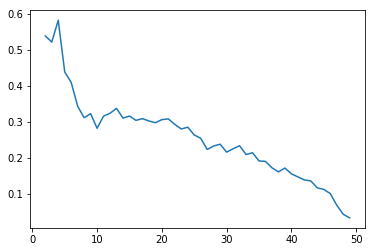

In [94]:
plt.plot(np.arange(2,max_clusters,1),silhouette)

In [77]:
nb_clusters = 4 

In [78]:
clusters = KMeans(n_clusters=nb_clusters).fit_predict(features_pca)

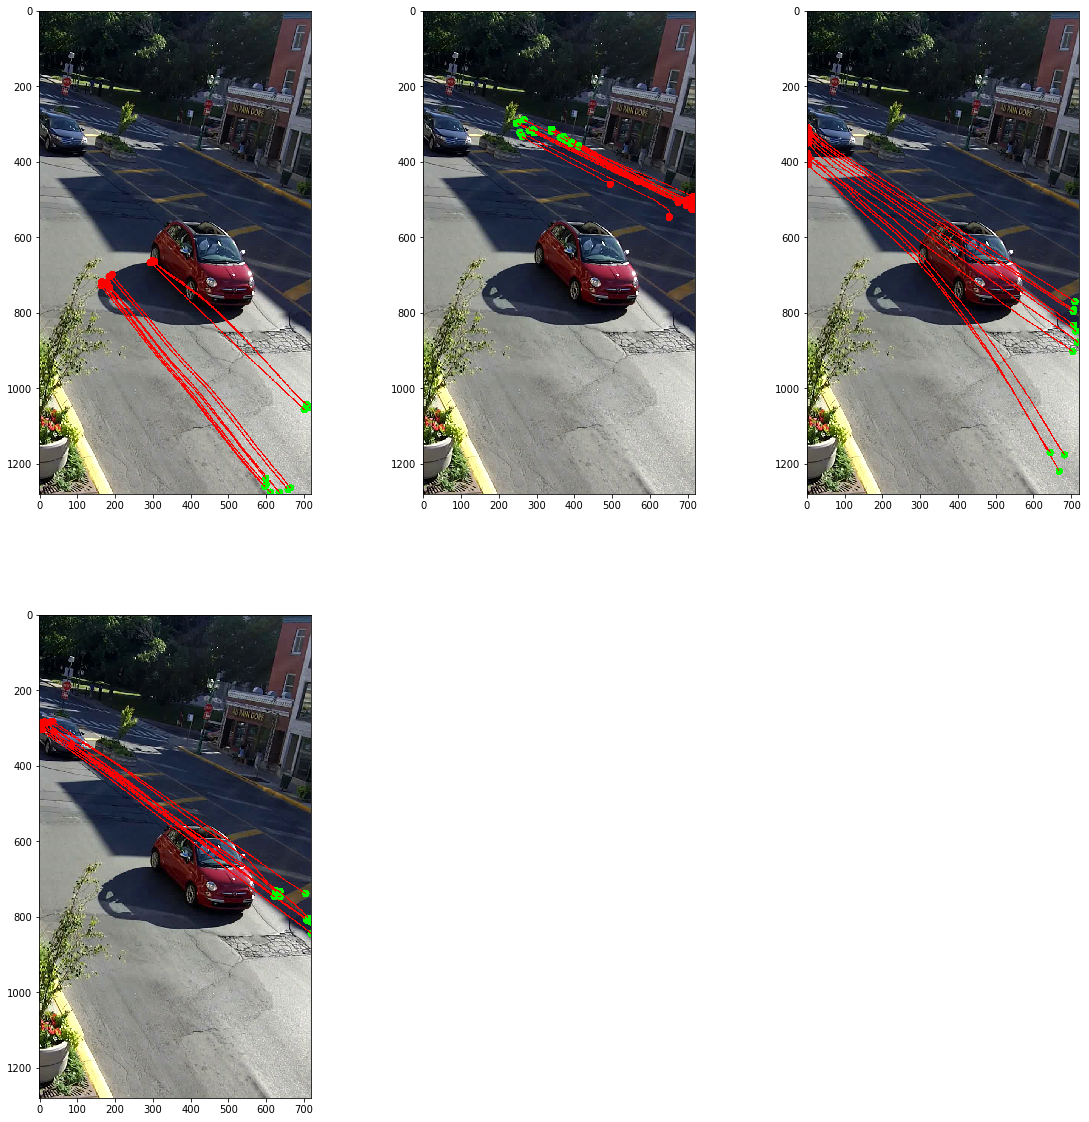

In [79]:
ut.display_clusters_oat_i(clusters,FRAME_PATH,pixel_trajectories)

### Stats about clusters

mean x

<BarContainer object of 4 artists>

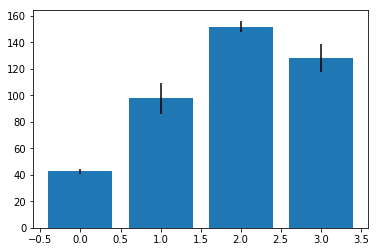

In [80]:
stats = ce.get_clusters_stats(trajectories,nb_clusters,clusters)
plt.bar(np.arange(0,nb_clusters),stats[:,0,0],yerr = stats[:,1,0])

mean y

<BarContainer object of 4 artists>

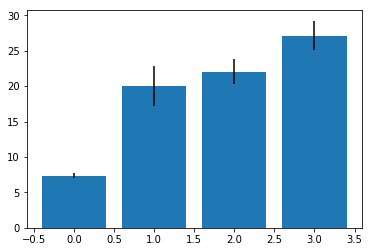

In [81]:
stats = ce.get_clusters_stats(trajectories,nb_clusters,clusters)
plt.bar(np.arange(0,nb_clusters),stats[:,0,1],yerr = stats[:,1,1])

mean velocity of a cluster

<BarContainer object of 4 artists>

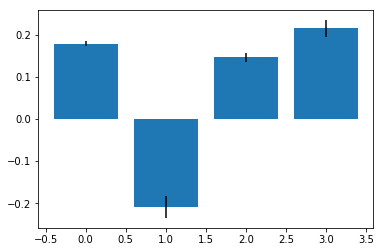

In [82]:
stats = ce.get_clusters_stats(trajectories,nb_clusters,clusters)
plt.bar(np.arange(0,nb_clusters),stats[:,0,2],yerr = stats[:,1,2])

mean rate of turn of a cluster

<BarContainer object of 4 artists>

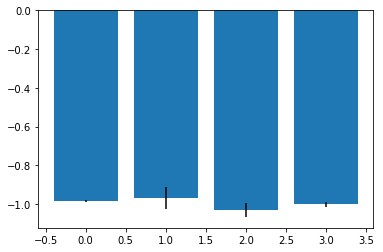

In [83]:
plt.bar(np.arange(0,nb_clusters),stats[:,0,3],yerr = stats[:,1,3])

# Observations/Conclusions

On a pu observer avec une méthode d'évaluation supervisée qu'une légère discrétisation (0.111) permet d'améliorer le clustering.
La PCA appliquée sur les 50 features issues des trajectoires discrétisées permet de conserver 99% de la variance des données en réduisant ces dernières à 13 dimensions.

L'utilisation de PCA + discrétisation augmente les performances de l'algorithme (en temps et en résultat).

Pour l'algorithme de k-médoid, on remarque que les features brutes (sans PCA, ni discrétisation) permettent de retrouver exactement le ground truth dans cette configuration.

Cependant, lorsqu'appliqué de manière non supervisée le k-médoid propose un nombre de cluster optimal de 9 clusters ce qui semble loin de la réalité.

Lorsqu'on applique la discrétisation et la PCA, les trois algorithmes donnent le même résultat de manière non supervisée et le nombre de cluster optimal proposé est de 4 ce qui est proche du groundtruth(5 clusters)

Les statistiques observées permettent de remarquer que dans cette configuration, les clusters ont été principalement discriminés par leurs positions et vitesses moyennes.

Les statistiques permettent de vérifier que les trajectoires ont été regroupées selon des critères cohérents.